The qubit is modeled by the drift Hamiltonian:
$$H_{drift}=\frac{\omega}{2}Z$$
to which we apply the drive:
$$H_{drive}(t)=\frac{r\Omega(t)}{2}X$$

Here $\Omega(t)$ is the drive signal - created with Qiskit pulse.

Factor $r$ - strength of driving signal

# Create pulse schedule

In [12]:
from qiskit.providers.fake_provider import FakeValencia

be = FakeValencia()

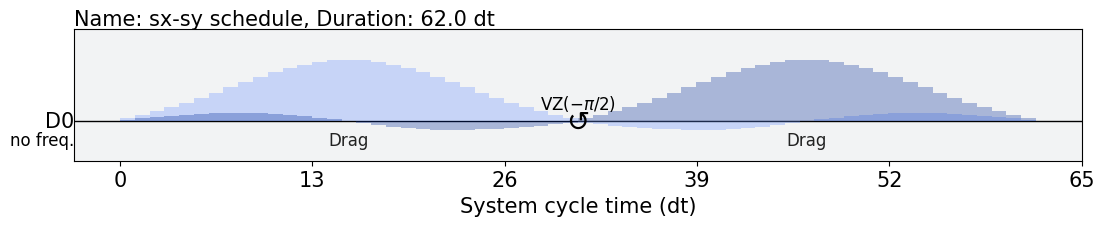

In [20]:
import numpy as np
import qiskit.pulse as pulse

# Strength of the Rabi-rate in GHz
r = 0.1

# Freq of the qubit transition in GHz
w = 5.

# Sample rate of the backend in ns
# dt = 0.222
dt = 0.5

# Define gaussian envelope to have a pi rotation
amp = 1.
area = 1
sig = area*0.399128/r/amp
T = 4*sig
duration = int(T/dt)
beta = 2.

# 1.75 factor is used to approximately get sx gate.
# Further "calibration" could be done to refine the pulse amplitude
# with pulse.build(name="sx-sy schedule") as xp:
with pulse.build(name="sx-sy schedule") as xp:
    pulse.play(pulse.Drag(duration, amp/1.75, sig/dt, beta),
              pulse.DriveChannel(0))
    pulse.shift_phase(np.pi/2, pulse.DriveChannel(0))
    pulse.play(pulse.Drag(duration, amp/1.75, sig/dt, beta),
              pulse.DriveChannel(0))

xp.draw()

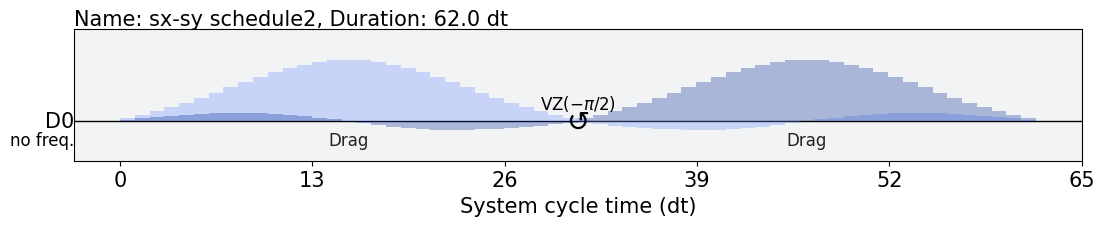

In [21]:
with pulse.build(backend=be, name="sx-sy schedule2") as xp2:
    pulse.play(pulse.Drag(duration, amp/1.75, sig/dt, beta),
              pulse.DriveChannel(0))
    pulse.shift_phase(np.pi/2, pulse.DriveChannel(0))
    pulse.play(pulse.Drag(duration, amp/1.75, sig/dt, beta),
              pulse.DriveChannel(0))

xp2.draw()

# Convert to signal

Convert to instances of `Signal`.
Plots below show the envelopes and the signal resulting from this conversion. The dashed line shows the time at which the virtual `z` is applied.

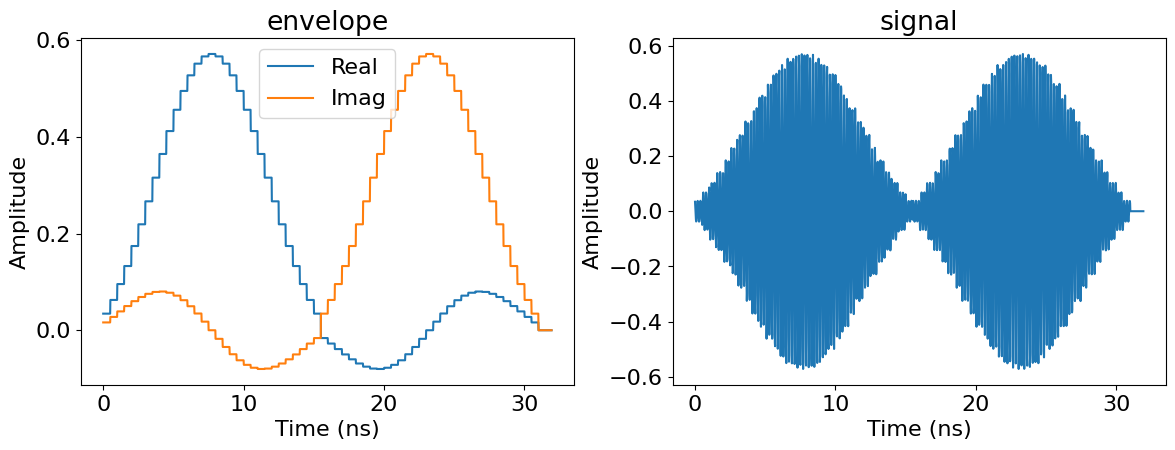

In [3]:
import matplotlib.pyplot as plt
import qiskit_dynamics.pulse as qdp

plt.rcParams["font.size"] = 16

converter = qdp.InstructionToSignals(dt, carriers={"d0": w})

total_duration = 2 * T

signals = converter.get_signals(xp)
fig, axs = plt.subplots(1, 2, figsize=(14, 4.5))
for ax, title in zip(axs, ["envelope", "signal"]):
#     signals[0].draw(0, 2*T, 2000, title, axis=ax)
    signals[0].draw(0, total_duration, 2000, title, axis=ax)
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
#     ax.vlines(T, ax.get_ylim()[0], ax.get_ylim()[1], "k", ls="dashed")

# start = dt * 60
# end = dt*80
# axs[-1].set_xlim((start, end))
# axs[-1].set_ylim((-0.1, 0.1))
    

# Create the system model

Setup `Solver` instance with desired Hamiltonian informatino & configure it to simiulate pulse schedules. Requires specifying which channels act on which operators, channel carrier frequencies and sample width `dt`. Additionaly setup solver int he rotating frame and perform the rotating wave approximation.

In [5]:
from qiskit.quantum_info.operators import Operator
from qiskit_dynamics import Solver

# construct operators
X = Operator.from_label('X')
Z = Operator.from_label('Z')

drift = 2 * np.pi * w * Z/2
operators = [2 * np.pi * r * X/2]

# construct solver
hamiltonian_solver = Solver(
    static_hamiltonian=drift,
    hamiltonian_operators=operators,
    rotating_frame=drift,
    rwa_cutoff_freq=2*5.,
    hamiltonian_channels=['d0'],
    channel_carrier_freqs={'d0': w},
    dt=dt
)

# Simulate pulse schedule using the model

Last step - perform simulation and plot results. Note, as we have configured `hamiltonian_solver` to simulate pulse schedules, we pass the schedule `xp` directly to the `signals` argument of the `solve` method. Equivalently, `signals` generated by the `converter.get_signals` above can also be passed to the `signals` argument and in this case should produce identical behaviour.

In [9]:
from qiskit.quantum_info.states import Statevector

# Start the qubit in its ground state
y0 = Statevector([1., 0.])

%time sol = hamiltonian_solver.solve(t_span=[0., 2*T], y0=y0, \
                                     signals=xp, atol=1e-8, rtol=1e-8)
# %time sol = hamiltonian_solver.solve(t_span=[0., T], y0=y0, \
#                                      signals=xp, atol=1e-8, rtol=1e-8)


CPU times: user 11.3 s, sys: 5.95 ms, total: 11.3 s
Wall time: 11.3 s


In [10]:
def plot_populations(sol):
    pop0 = [psi.probabilities()[0] for psi in sol.y]
    pop1 = [psi.probabilities()[1] for psi in sol.y]
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(sol.t, pop0, lw=3, label="Population in |0>")
    ax.plot(sol.t, pop1, lw=3, label="Population in |1>")
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Population (probabilies)")
    ax.legend(frameon=False)
    ax.set_ylim([0, 1.05])
    ax.set_xlim([0, 2*T])
    ax.vlines(T, 0, 1.05, "k", ls='dashed')
    print(T)

15.965119999999999


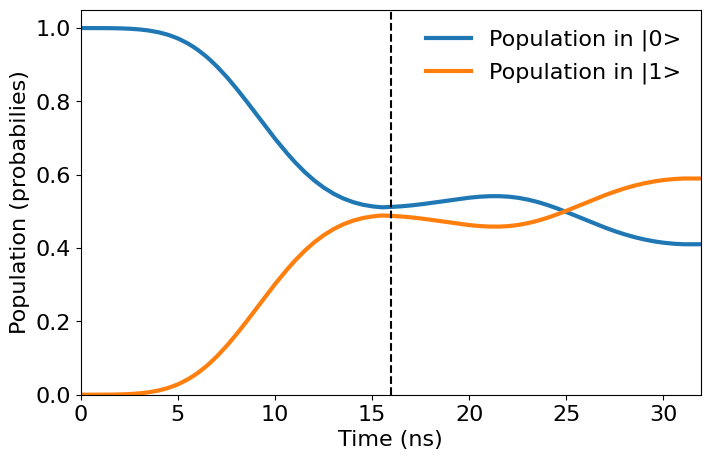

In [11]:
plot_populations(sol)

The plot above shows the population of the qubit as it evolves during the pulses. Ther vertical dashed line shows the time of the virtual Z rotation which was induced by the `shift_phase` instruction in the pulse schedule. As expected, the first pulse moves the qbuit to an eigenstate of the `Y` operator. Therefore, the second pulse, which drives the `Y`-axis due to the phase shift, has hardly any influence on the populations of the qubit.